 ## **Clean the Data (deal with missing values):**

There are no missing values in this dataset, and each image has the exact same shape. From the website: "The CIFAR-10 dataset consists of *60000 32x32 colour images in 10 classes, with 6000 images per class.* There are **50000 training images and 10000 test images.**

*The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class.* The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class."

For this reason, train/test splitting is already done intrinsically (by the owner of the CIFAR-10 dataset), and the data must simply be loaded and differentiated properly to be properly used.

## **Create/Implement a Custom Transformer:**

Each image starts as a 32x32x3 vector of data, containing the RGB values for each pixel in a 32x32 image one after another. To be used in most machine learning algorithms, each image must be one single instance (row). Thus, each image will be reshaped to one vector of (32 * 32 * 3) = 3072 values.

In [3]:
#eloquent solution on stack overflow:
#https://stackoverflow.com/questions/37512290/reading-cifar10-dataset-in-batches

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from six.moves import cPickle as pickle
import os
import platform
from subprocess import check_output
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

%matplotlib inline


img_rows, img_cols = 32, 32
input_shape = (img_rows, img_cols, 3)
def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == '2':
        return  pickle.load(f)
    elif version[0] == '3':
        return  pickle.load(f, encoding='latin1')
    raise ValueError("invalid python version: {}".format(version))

def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, 'rb') as f:
        datadict = load_pickle(f)
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000,3072)
        Y = np.array(Y)
        return X, Y

def load_CIFAR10(ROOT):
    """ load all of cifar """
    xs = []
    ys = []
    for b in range(1,6): #there are five files (data_batch_1 through data_batch_5)
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cifar-10-python.tar\cifar-10-python\cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    x_train = X_train.astype('float32')
    x_test = X_test.astype('float32')

    x_train /= 255
    x_test /= 255

    return x_train, y_train, X_val, y_val, x_test, y_test


# Invoke the above function to get our data.
x_train, y_train, x_val, y_val, x_test, y_test = get_CIFAR10_data()


print('Train data shape: ', x_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', x_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', x_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (10000, 3072)
Test labels shape:  (10000,)


 ## **Use sklearn.neighbors.KNeighborsClassifier:**

In [5]:
from sklearn.neighbors import KNeighborsClassifier

In [8]:
#As an initial test, let's use the default for K in sci-kit learn's KNN algorithm (k = 5)
knn = KNeighborsClassifier(n_neighbors=5)

In [9]:
knn.fit(x_train, y_train)

KNeighborsClassifier()

In [14]:
#testing on a single sample
knn.predict(x_train[0].reshape(1,-1))

array([4])

In [13]:
knn.predict_proba(x_train[0].reshape(1,-1))

array([[0. , 0. , 0.2, 0. , 0.6, 0. , 0.2, 0. , 0. , 0. ]])

In [15]:
#class labels =  airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck
#So, the classifier thinks this is a deer

6

6

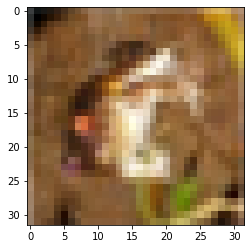

In [19]:
#let's see what the image actually is, visually
import matplotlib.pyplot as plt

image = x_train[0, :]
image = np.reshape(image, (32,32,3), order='F' ) 
plt.imshow(image)

y_train[0]

In [ ]:
#this appears to be a frog (class 6), not a deer (class 4)
#Was this just a fluke, though, or are none of the predictions particularly accurate?

In [22]:
from sklearn.model_selection import cross_val_score
mae_A = cross_val_score(knn, x_val, y_val, scoring="neg_mean_absolute_error", cv=10)

In [24]:
mae = mae_A.mean()
stdAccuracy = mae_A.std()
print("Mean Absolute Error: %.2f, Standard Deviation : %.2f" % (mae, stdAccuracy))

Mean Absolute Error: -2.76, Standard Deviation : 0.28


In [28]:
accuracy = cross_val_score(knn, x_val, y_val, scoring="accuracy", cv=10)
print("Accuracy: %.2f, Standard Deviation: %.2f" % (accuracy.mean(), accuracy.std()))

Accuracy: 0.22, Standard Deviation: 0.04


At least it's *consistently* wrong, right? Let's try to make it better with GridSearch.

## **Use Grid Search CV or RandomizedSearch CV to tune hyperparameters for a model**

In [31]:
#training with grid-search from https://machinelearningknowledge.ai/knn-classifier-in-sklearn-using-gridsearchcv-with-example/
from sklearn.model_selection import GridSearchCV
ks = list(range(1, 11))
param_grid = dict(n_neighbors=ks)

grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', return_train_score=False,verbose=1)
  
# fitting the model for grid search
grid_search=grid.fit(x_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [33]:
print("Best Accuracy is ", grid_search.best_score_*100, " with a k value of ", grid_search.best_params_)

Best Accuracy is  34.33673469387755  with a k value of  {'n_neighbors': 1}


Based on our gridsearch, our best value for K is 1.

Now, with this model, we can test and deploy it.

## **Evaluate your system on the Test Data**

In [34]:
knn_updated = KNeighborsClassifier(n_neighbors=1)

In [35]:
knn_updated.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [37]:
mae_B = cross_val_score(knn_updated, x_test, y_test, scoring="neg_mean_absolute_error", cv=10)
mae_updated = mae_B.mean()
stdAccuracy_updated = mae_B.std()
print("Mean Absolute Error: %.2f, Standard Deviation : %.2f" % (mae_updated, stdAccuracy_updated))

Mean Absolute Error: -2.41, Standard Deviation : 0.06


In [38]:
accuracy_updated = cross_val_score(knn_updated, x_test, y_test, scoring="accuracy", cv=10)
print("Accuracy: %.2f, Standard Deviation: %.2f" % (accuracy_updated.mean(), accuracy_updated.std()))

Accuracy: 0.29, Standard Deviation: 0.01


Optimizing our parameters with GridSearch lowered our MAE from 2.76 to 2.41 a